# Toy examples using Stan

I estimate the Preston, box-cox, and log quadratic model using data from 1950+. Are these models comparable? No, but the Jacobian adjustment should do the the trick. I am not sure if I am doing the correct thing, need some math assistance.



In [219]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

library(loo)
library(haven)
library(sdazar)
library(MASS)
library(ggplot2)

options(repr.plot.width = 7, repr.plot.height = 4)

# Using real data (1950 or more)

In [368]:
df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, tle := le/(1.05*max(le))]

df49 = copy(df)[year < 1950]
df50 = copy(df)[year >= 1950]

# using >=50
data = list(
    N = nrow(df50),
    x = df50$gdp, 
    y = df50$tle
)

saveRDS(data, '../data/example.rds')

# Preston Model

## Frequentist

In [168]:
# estimating starting values for the parameters. 
# Assume alpha=1, then estimate logit(yvar)=beta+gamma^GDP

In [170]:
pars = nls(log(y) ~ beta+exp(log(C)*x),
      data=data,
      start=list(beta=1,C=1))

In [173]:
nlsFormula = "y ~ alpha / (1 + exp( beta + exp(log(C) * x )))"
nlsInitial = c(alpha=max(data$y),coef(pars)[1],coef(pars)[2])

In [175]:
model_preston = minpack.lm::nlsLM(formula = nlsFormula,
         data=data,
         start=nlsInitial,
     control=minpack.lm::nls.lm.control(maxiter=1000))

In [176]:
summary(model_preston)


Formula: y ~ alpha/(1 + exp(beta + exp(log(C) * x)))

Parameters:
       Estimate Std. Error  t value Pr(>|t|)    
alpha 2.6615949  1.0526279    2.529   0.0121 *  
beta  0.6915597  0.6118753    1.130   0.2595    
C     0.9995341  0.0001052 9505.206   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09476 on 237 degrees of freedom

Number of iterations to convergence: 11 
Achieved convergence tolerance: 1.49e-08


In [419]:
# plot for frequentist approach
plot_predictions = function (x, y, pred) {

    #rmse = sqrt(mean(residuals(model)^2))
    ggplot(data.frame(x, y, pred), aes(x = x, y = y)) +
    geom_point(size=0.7, color='#e34a33', alpha=0.4) + 
    geom_line(aes(x = x, y = pred), color='#2b8cbe', size = 0.4) +
   # labs(title = paste0("RMSE: ", round(rmse, 2))) + 
    theme_classic()

}

## Stan

In [471]:
stan_preston = '
    data {
      int<lower=0> N; 
      real x[N]; 
      real y[N]; 
    } 
    parameters {
      real alpha; 
      real beta;  
      real<lower=.5,upper= 1> C;
      real<lower=0> sigma; 
    } 
    model {
      real m[N];
      
      alpha ~ normal(0, 2); 
      beta ~ normal(0, 2); 
      C ~ uniform(0, 1); 
      
      for (i in 1:N) 
        m[i] = alpha / ( 1 + exp ( beta + exp ( log(C) * x[i])));

      y ~ normal(m, sigma); 

      }
    generated quantities{
      real y_pred[N];
      real log_lik[N];

      for(i in 1:N){
        y_pred[i] = normal_rng(alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma);   
        log_lik[i] = normal_lpdf(y[i] | alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma); // no need of adjustment
     }
    }
'

In [ ]:
fit_preston = stan(model_code = stan_preston, 
            model_name = "preston", 
            data = data)

In [202]:
print(fit_preston, pars=c('alpha', 'beta', 'C', 'sigma'))

Inference for Stan model: preston.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean   sd  2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha 2.67    0.03 0.77  1.69 2.15 2.52 2.99  4.71   722 1.00
beta  0.61    0.02 0.43 -0.13 0.34 0.60 0.87  1.47   589 1.01
C     0.99    0.01 0.04  1.00 1.00 1.00 1.00  1.00    45 1.06
sigma 0.10    0.00 0.01  0.09 0.09 0.09 0.10  0.11    69 1.05

Samples were drawn using NUTS(diag_e) at Thu Feb 15 13:37:37 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [472]:
# leave-one-out
loo(extract_log_lik(fit_preston, parameter_name = "log_lik"))

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    223.0 10.7
p_loo         3.3  0.4
looic      -446.1 21.4

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

In [217]:
# plot function for posterior
plot_posterior = function(stan_model, x, y, pred_name='y_pred', ylabel='y ', xlabel='x',
                          prob=0.90) {
    
    ypred = extract(stan_model, pred_name)[[1]]
    
    m =  as.vector(apply(ypred, 2, median))
    lo = as.vector(apply(ypred, 2, function(x) quantile(x, prob=(1-prob))))
    hi = as.vector(apply(ypred, 2, function(x) quantile(x, prob=prob)))
        
    dat = data.frame(y, x, m, lo, hi)
    
    ggplot(dat, aes(x=x, y=y)) + 
        geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
        geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
        geom_point(size=0.7, color='#e34a33', alpha=0.4) + 
        labs(x=xlabel, y=ylabel) + 
        theme_classic()

}

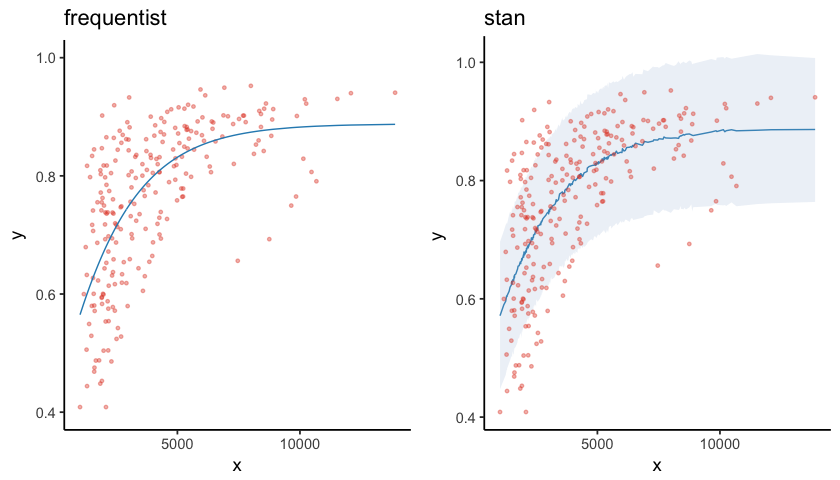

In [473]:
# plots
plot1 = plot_predictions(data$x,data$y, pred=predict(model_preston)) + ylim(0.4, 1.0) + labs(title='frequentist')
plot2 = plot_posterior(fit_preston, data$x, data$y) + labs(title='stan')
gridExtra::grid.arrange(plot1, plot2, ncol=2)

# Boxcox

## Frequentist

In [483]:
bc = boxcox(data$y~log(data$x),plotit=FALSE,lambda=seq(0,3,0.01))

In [484]:
lambda = bc$x[bc$y==max(bc$y)]

In [485]:
lambda=1.12 # big lambda

In [486]:
if(lambda==0) {y = log(data$y)}
if(lambda!=0) {y = (data$y^lambda -1)/lambda}
model_bc = lm(y ~ log(data$x))

In [487]:
summary(model_bc)


Call:
lm(formula = y ~ log(data$x))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.25927 -0.05709  0.01040  0.05885  0.21943 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.39144    0.08568  -16.24   <2e-16 ***
log(data$x)  0.14204    0.01047   13.57   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09192 on 238 degrees of freedom
Multiple R-squared:  0.4361,	Adjusted R-squared:  0.4338 
F-statistic: 184.1 on 1 and 238 DF,  p-value: < 2.2e-16


In [475]:
preds = predict(model)

In [476]:
plot_predictions_bc = function (model, x, y, lambda) {

    pred = predict(model)
    pred = sapply(pred, function(x) (x*lambda + 1)^(1/lambda))
    ggplot(data.frame(x, y, pred), aes(x = x, y = y)) +
    geom_point(size=0.7, color='#e34a33', alpha=0.4) + 
    geom_line(aes(x = x, y = pred), color='#2b8cbe', size = 0.4) +
   # labs(title = paste0("RMSE: ", round(rmse, 2))) + 
    theme_classic()

}

## Stan

In [491]:
stan_boxcox = '
    data {
        int<lower=0> N;
        real x[N]; 
        real y[N]; 
    }

    parameters {
        real alpha;
        real beta;
        real lambda;
        real<lower=0> sigma;
    }

    model {
        lambda ~ normal(0,3);
        beta ~ normal(0,0.5);
        alpha ~ normal(0,2);
        sigma ~ cauchy(0, 5);

      if(lambda == 0){
            for(i in 1:N) {
                    log(y[i]) ~ normal(alpha + log(x[i])*beta, sigma);
                    target += -log(y[i]);
            }
        } else {
            for(i in 1:N){
                    (y[i]^lambda - 1)/lambda ~ normal(alpha + log(x[i])*beta, sigma);
                    target += (lambda - 1)*log(y[i]);
                }
            }
        }

    generated quantities {
       real rvalue[N];
       real y_pred[N];
       real log_lik[N];

    for(n in 1:N){
           if(lambda != 0) {

             rvalue[n] = normal_rng(alpha + log(x[n])*beta, sigma);

             if (is_nan((rvalue[n] * lambda + 1)^(1/lambda))) {
                y_pred[n] = 0; // very crude solution!
             } else { 
                 y_pred[n] = (rvalue[n] * lambda + 1)^(1/lambda);
                }
               
        //if(is_nan(y_pred[n])) { // for assessing bugs
            //print(alpha);
            //print(log(x[n]));
            //print(beta);
            //print(sigma);
            //print(lambda);
        //}

             log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma) + (lambda-1)*log(y[n]); // is this right?
            //log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma);
            
            } else {
             rvalue[n] = normal_rng(alpha + log(x[n])*beta, sigma);
             y_pred[n] = exp(rvalue[n]);
            log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma) - log(y[n]); // this is right!
            //log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma);

           }
         }
    }
    '

In [ ]:
fit_boxcox = stan(model_code = stan_boxcox, 
            model_name = 'boxcox', 
            data = data)

In [494]:
print(fit_boxcox, pars=c('alpha', 'beta', 'lambda', 'sigma'))

Inference for Stan model: boxcox.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha  -0.85    0.00 0.09 -1.04 -0.91 -0.85 -0.79 -0.69   829    1
beta    0.08    0.00 0.01  0.06  0.08  0.08  0.09  0.10   843    1
lambda  2.91    0.01 0.35  2.26  2.67  2.90  3.14  3.60   894    1
sigma   0.05    0.00 0.01  0.04  0.05  0.05  0.06  0.06   914    1

Samples were drawn using NUTS(diag_e) at Thu Feb 15 15:55:50 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [495]:
loo(extract_log_lik(fit_boxcox, parameter_name = "log_lik"))

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    237.1 11.9
p_loo         3.4  0.3
looic      -474.2 23.8

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

### Look at the uncertainty at the bottom of the distribution!!!!

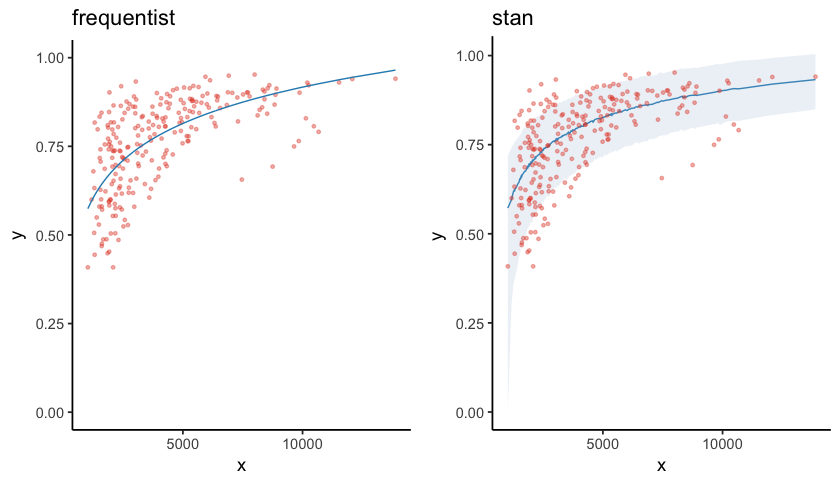

In [496]:
options(repr.plot.width = 7, repr.plot.height = 4)
plot1 = plot_predictions_bc(model, data$x, data$y, lambda) + ylim(0, 1) + labs(title='frequentist')
plot2 = plot_posterior(fit_boxcox, data$x, data$y, 'y_pred') + labs(title='stan')
gridExtra::grid.arrange(plot1, plot2, ncol=2)

### Problem transforming extreme values from posterior distribution

What to do? Discussion here: http://discourse.mc-stan.org/t/problem-recovering-generated-predictions-for-box-cox-model/3315

In [458]:
# example using data estimated by stan
alpha = -1.26999
logx = 7.90211
beta = 0.101912
lambda = 1.05
sigma = 0.316502

In [459]:
a = rnorm(100, alpha + beta*logx, sigma) # get random values from normal distriution

df = data.table(value = a, tf = (a * lambda + 1)^(1/lambda))
df[is.na(df$tf),] # not able to transform extreme numbers

value,tf
-1.046877,NaN
-1.030949,NaN
-1.043105,NaN
-1.093262,NaN
-1.039815,NaN


In [462]:
setorder(df, value)
head(df)

value,tf
-1.0932616,NaN
-1.0468766,NaN
-1.0431053,NaN
-1.0398149,NaN
-1.0309495,NaN
-0.9454715,0.009172948


# Log and quadratic model

## Frequentist

In [422]:
logx2 = log(data$x)^2

In [423]:
model_log = lm(log(data$y) ~ 1 + log(data$x) + logx2)

In [429]:
summary(model_log)


Call:
lm(formula = log(data$y) ~ 1 + log(data$x) + logx2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50026 -0.08093  0.02246  0.08355  0.34821 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.37960    1.78483  -4.135 4.94e-05 ***
log(data$x)  1.52791    0.43567   3.507 0.000542 ***
logx2       -0.08033    0.02649  -3.032 0.002698 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.139 on 237 degrees of freedom
Multiple R-squared:  0.4336,	Adjusted R-squared:  0.4289 
F-statistic: 90.73 on 2 and 237 DF,  p-value: < 2.2e-16


## Stan

In [433]:
stan_log = '
    data {
        int<lower=0> N;
        real y[N];
        real x[N];
    }

    parameters {
        real alpha;
        real beta1;
        real beta2;
        real<lower=0> sigma;
    }

    model {
        beta1 ~ normal(0,2);
        beta2 ~ normal(0,2);
        alpha ~ normal(-7,1);

        for (i in 1:N) {
            log(y[i]) ~ normal(alpha + log(x[i])*beta1 + log(x[i])^2*beta2, sigma);
        }
}

    generated quantities {
       vector[N] y_pred;
       vector[N] log_lik;
        
        for (n in 1:N) {
        log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta1 + log(x[n])^2*beta2, sigma) - log(y[n]);
        y_pred[n] = exp(normal_rng(alpha + log(x[n])*beta1 + log(x[n])^2*beta2, sigma));
         }
        }
    '

In [ ]:
fit_log = stan(model_code = stan_log, 
            model_name = "log",
            data = data)

In [435]:
print(fit_log, pars=c('alpha', 'beta1', 'beta2', 'sigma'))

Inference for Stan model: log.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha -7.06    0.03 0.87 -8.77 -7.64 -7.04 -6.48 -5.33   745 1.01
beta1  1.45    0.01 0.21  1.03  1.31  1.45  1.59  1.87   747 1.01
beta2 -0.08    0.00 0.01 -0.10 -0.08 -0.08 -0.07 -0.05   755 1.01
sigma  0.14    0.00 0.01  0.13  0.14  0.14  0.14  0.15  1189 1.00

Samples were drawn using NUTS(diag_e) at Thu Feb 15 15:37:23 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [356]:
#traceplot(fit_log, pars=c('alpha', 'beta1', 'beta2', 'sigma'))

In [436]:
loo(extract_log_lik(fit_log, parameter_name = "log_lik"))

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    199.6 11.5
p_loo         3.7  0.6
looic      -399.2 22.9

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

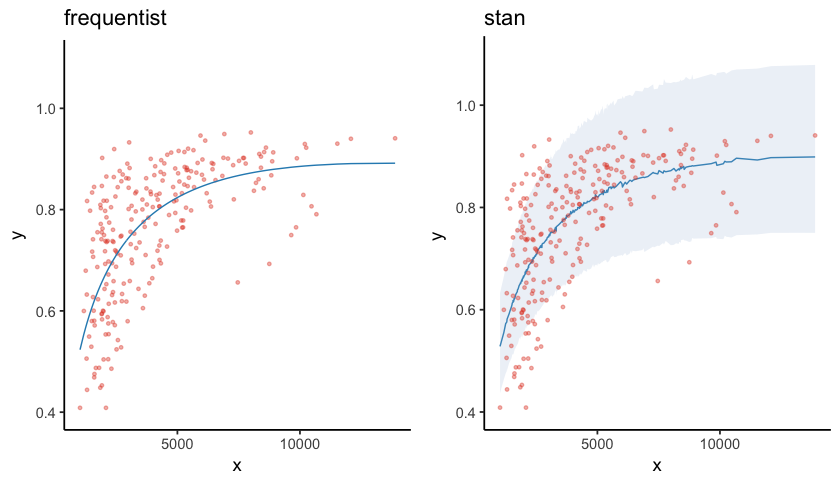

In [463]:
plot1 = plot_predictions(data$x, data$y, exp(predict(model_log))) + ylim(0.4, 1.1) + labs(title='frequentist')
plot2 = plot_posterior(fit_log, data$x, data$y) + ylim(0.4, 1.1) + labs(title='stan')
gridExtra::grid.arrange(plot1, plot2, ncol=2)

# Averaging or stacking weights

In [464]:
log_lik_list = list()
log_lik_list[[1]] = extract_log_lik(fit_preston, parameter_name = "log_lik")
log_lik_list[[2]] = extract_log_lik(fit_log, parameter_name = "log_lik") 
log_lik_list[[3]] = extract_log_lik(fit_boxcox, parameter_name = "log_lik") 

In [469]:
loo::model_weights(log_lik_list, method='stacking')

The stacking weights are:
     [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "0"       "1"      


[1] 3.117871e-05 3.579503e-07 9.999685e-01

In [470]:
loo::model_weights(log_lik_list, method='pseudobma')

The Pseudo-BMA+ weights using Bayesian Bootstrap  are:
      [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "0"       "1"      


[1] 2.725542e-03 1.266781e-09 9.972745e-01

Difference between  models is pretty strong... averaging is giving weight 1 to one of the models (box-cox), in other words, no need to average but to use the best model!